In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './shallow_nn_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

2024-04-14 19:18:21.455106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 19:18:22.328270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_39958/1763327434.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Tuning hyperparameters 

In [2]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],  # Number of hidden units
    'activation': ['relu', 'tanh', 'logistic'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength (L2 penalty)
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
}    

In [3]:

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Tunning to each specific set

## Under Sampling - No selection

In [4]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



2024-04-14 19:18:23.054761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 19:18:23.080090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 19:18:23.080379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Reloading Tuner from ./shallow_nn_out/under_no_sel_shallow_nn/tuner0.json


L355
2024-04-14 19:18:23.081923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 19:18:23.082106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 19:18:23.158460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [5]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 128
- activation: sigmoid
- learning_rate: 0.001

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


I0000 00:00:1713118703.821824   40700 service.cc:145] XLA service 0x7ebccc0051a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713118703.821851   40700 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-14 19:18:23.845584: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 19:18:23.948939: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/14 ━━━━━━━━━━━━━━━━━━━━ 11s 877ms/step - accuracy: 0.6250 - loss: 0.6475

I0000 00:00:1713118704.171522   40700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6085 - loss: 0.6282 - val_accuracy: 0.8802 - val_loss: 0.5964
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8859 - loss: 0.4399 - val_accuracy: 0.9954 - val_loss: 0.3901
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8981 - loss: 0.3385 - val_accuracy: 0.9977 - val_loss: 0.2920
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8974 - loss: 0.2905 - val_accuracy: 0.9975 - val_loss: 0.2551
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9255 - loss: 0.2413 - val_accuracy: 0.9971 - val_loss: 0.2293
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9210 - loss: 0.2237 - val_accuracy: 0.9952 - val_loss: 0.2097
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9249 - loss: 0.2279 - val_accuracy: 0.9914 - val_loss: 0.1991
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9375 - loss: 0.1969 - val_accuracy: 0.9904 - val_loss: 0

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 663us/step - accuracy: 0.9662 - loss: 0.1300


# Plot of Training and Validation Accuracy/Loss

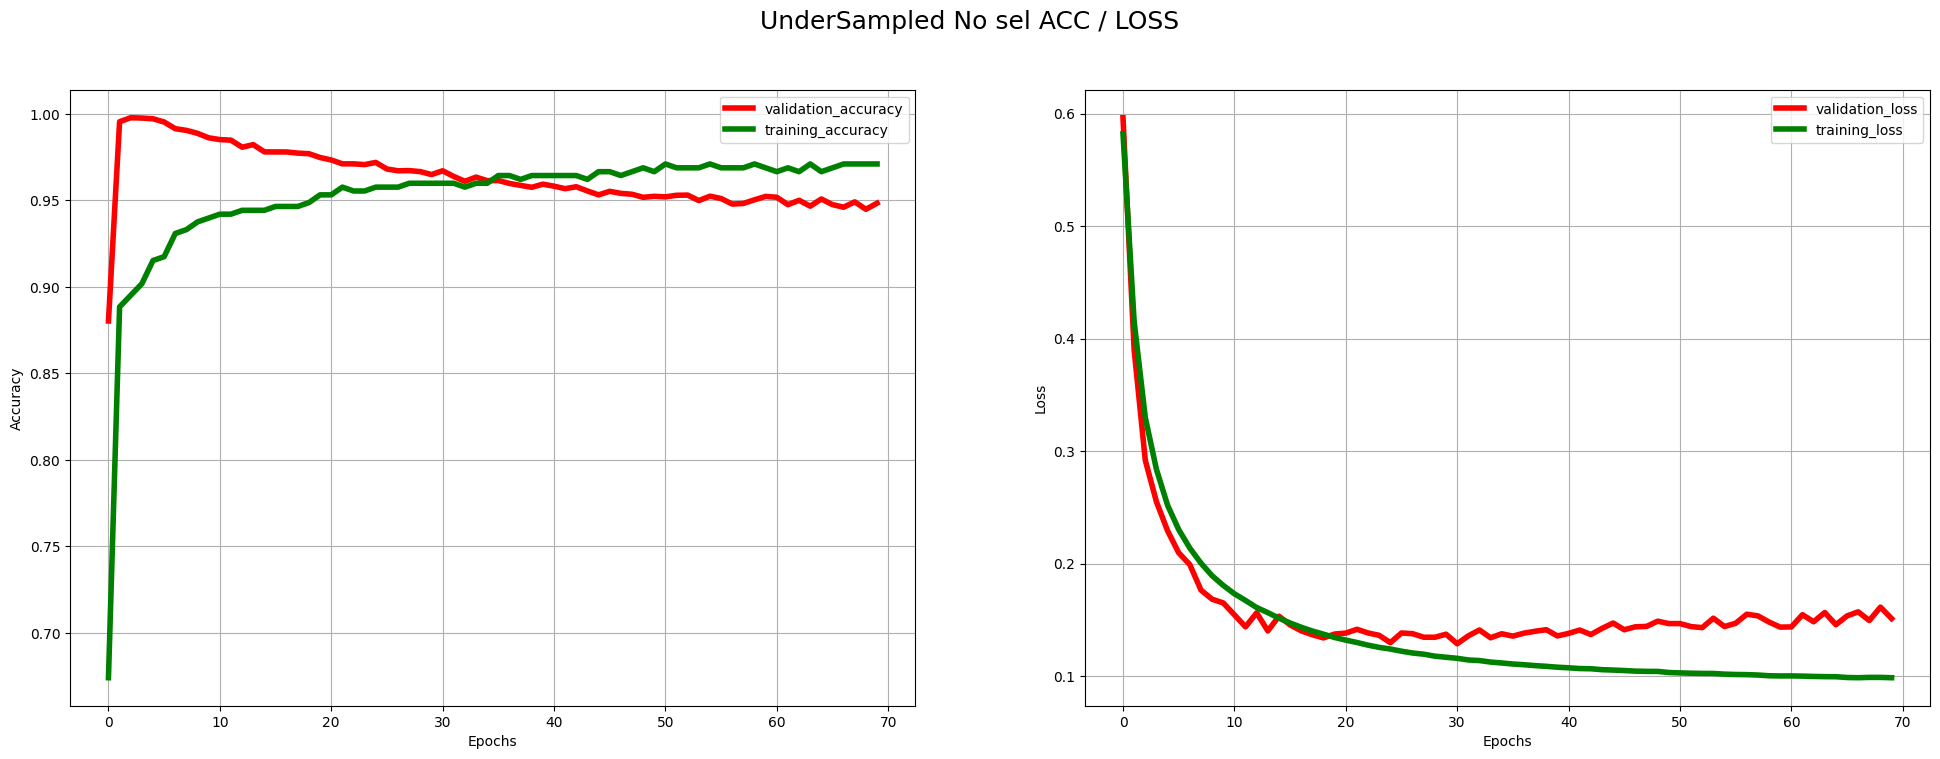

In [6]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step
[[96197  3314]
 [   19   153]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     99511
         1.0       0.04      0.89      0.08       172

    accuracy                           0.97     99683
   macro avg       0.52      0.93      0.53     99683
weighted avg       1.00      0.97      0.98     99683



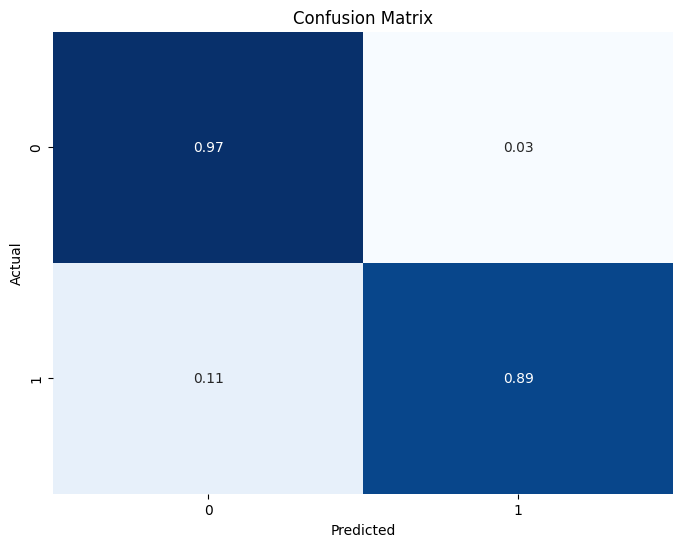

In [7]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Over Sampling - No selection

In [8]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



Reloading Tuner from ./shallow_nn_out/over_no_sel_shallow_nn/tuner0.json


In [9]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 96
- activation: sigmoid
- learning_rate: 0.01

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 808us/step - accuracy: 0.9834 - loss: 0.0458 - val_accuracy: 0.9988 - val_loss: 0.0063
Epoch 2/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 797us/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0052
Epoch 3/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 788us/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9993 - val_loss: 0.0053
Epoch 4/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 766us/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0048
Epoch 5/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 779us/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9993 - val_loss: 0.0049
Epoch 6/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 848us/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9992 - val_loss: 0.0061
Epoch 7/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 794us/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9994 - val_loss: 0.0054
Epoch 8/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 764us/step - accuracy: 0.9998 - loss: 0.00

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 765us/step - accuracy: 0.9992 - loss: 0.0081


# Plot of Training and Validation Accuracy/Loss

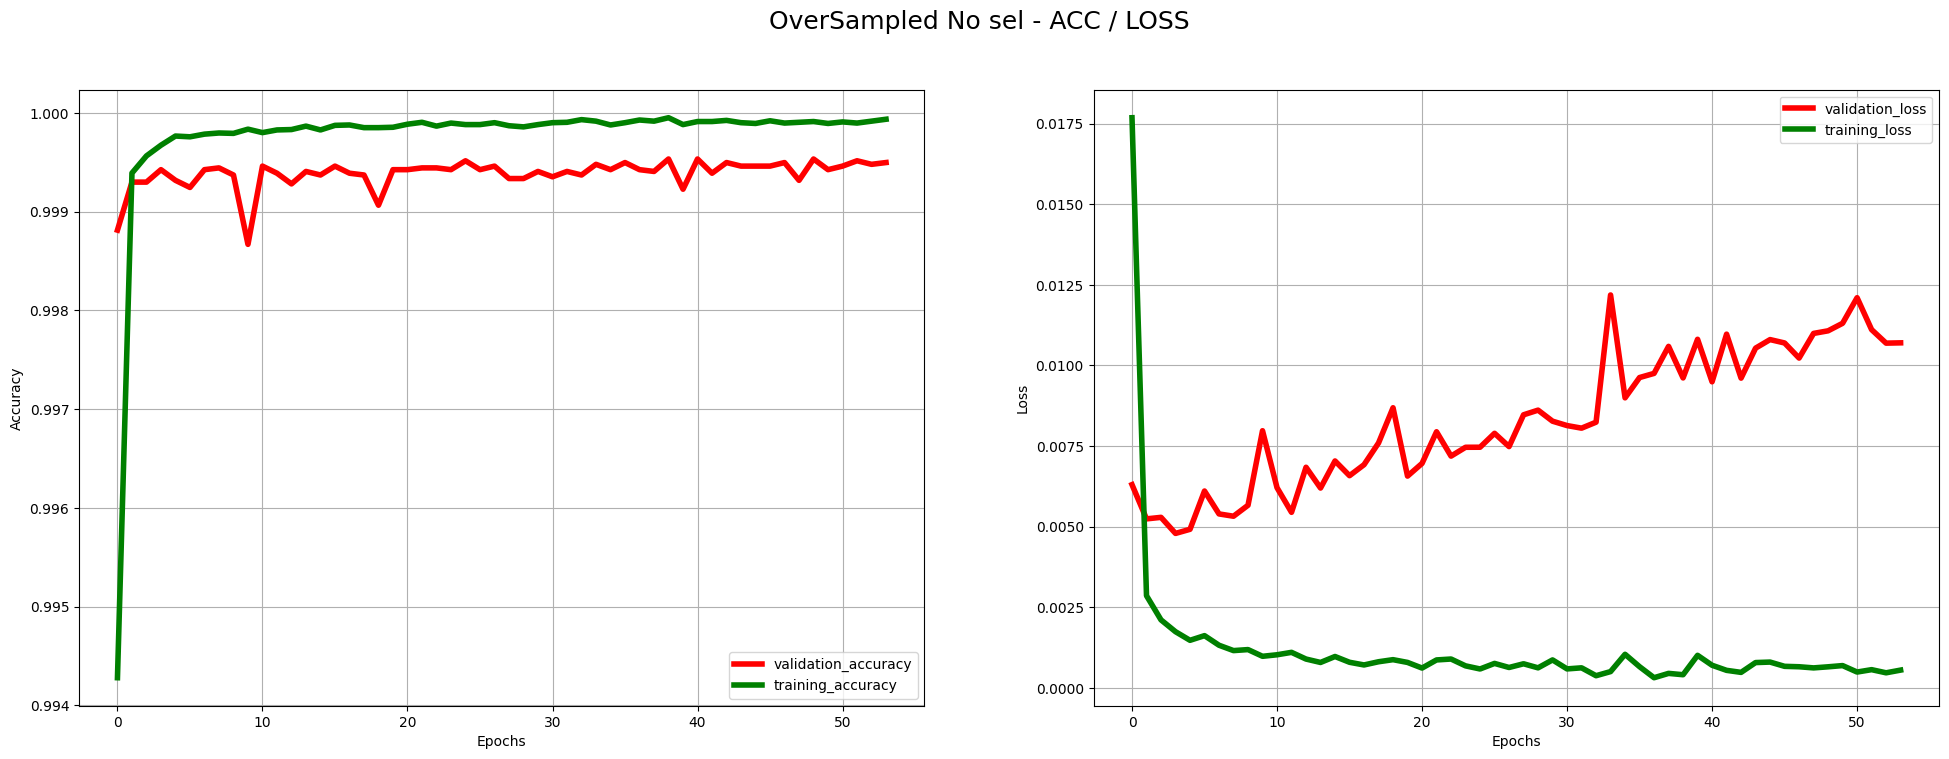

In [10]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step
[[99448    63]
 [   39   133]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99511
         1.0       0.68      0.77      0.72       172

    accuracy                           1.00     99683
   macro avg       0.84      0.89      0.86     99683
weighted avg       1.00      1.00      1.00     99683



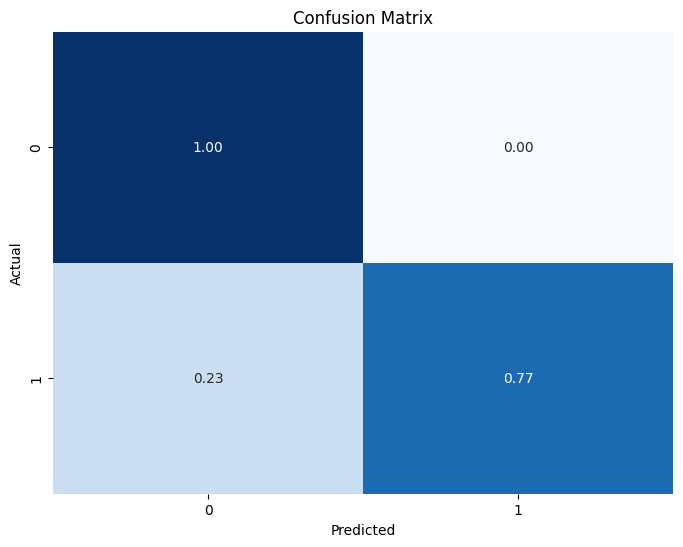

In [11]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# New builder

In [12]:

def build_best_under_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_under_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/under_best_sel_shallow_nn/tuner0.json


## Under Sampling - Best selection

In [13]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 256
- activation: sigmoid
- learning_rate: 0.001

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5211 - loss: 0.6399 - val_accuracy: 0.9892 - val_loss: 0.4981
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9179 - loss: 0.3658 - val_accuracy: 0.9988 - val_loss: 0.2804
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8955 - loss: 0.2949 - val_accuracy: 0.9986 - val_loss: 0.2214
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8962 - loss: 0.2741 - val_accuracy: 0.9978 - val_loss: 0.2000
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9247 - loss: 0.2212 - val_accuracy: 0.9973 - val_loss: 0.1749
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9210 - loss: 0.1967 - val_accuracy: 0.9926 - val_loss: 0.1742
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9130 - loss: 0.2295 - val_accuracy: 0.9914 - val_loss: 0.1666
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9321 - loss: 0.1976 - val_accuracy: 0.9905 - val_loss: 0

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - accuracy: 0.9801 - loss: 0.1307


# Plot of Training and Validation Accuracy/Loss

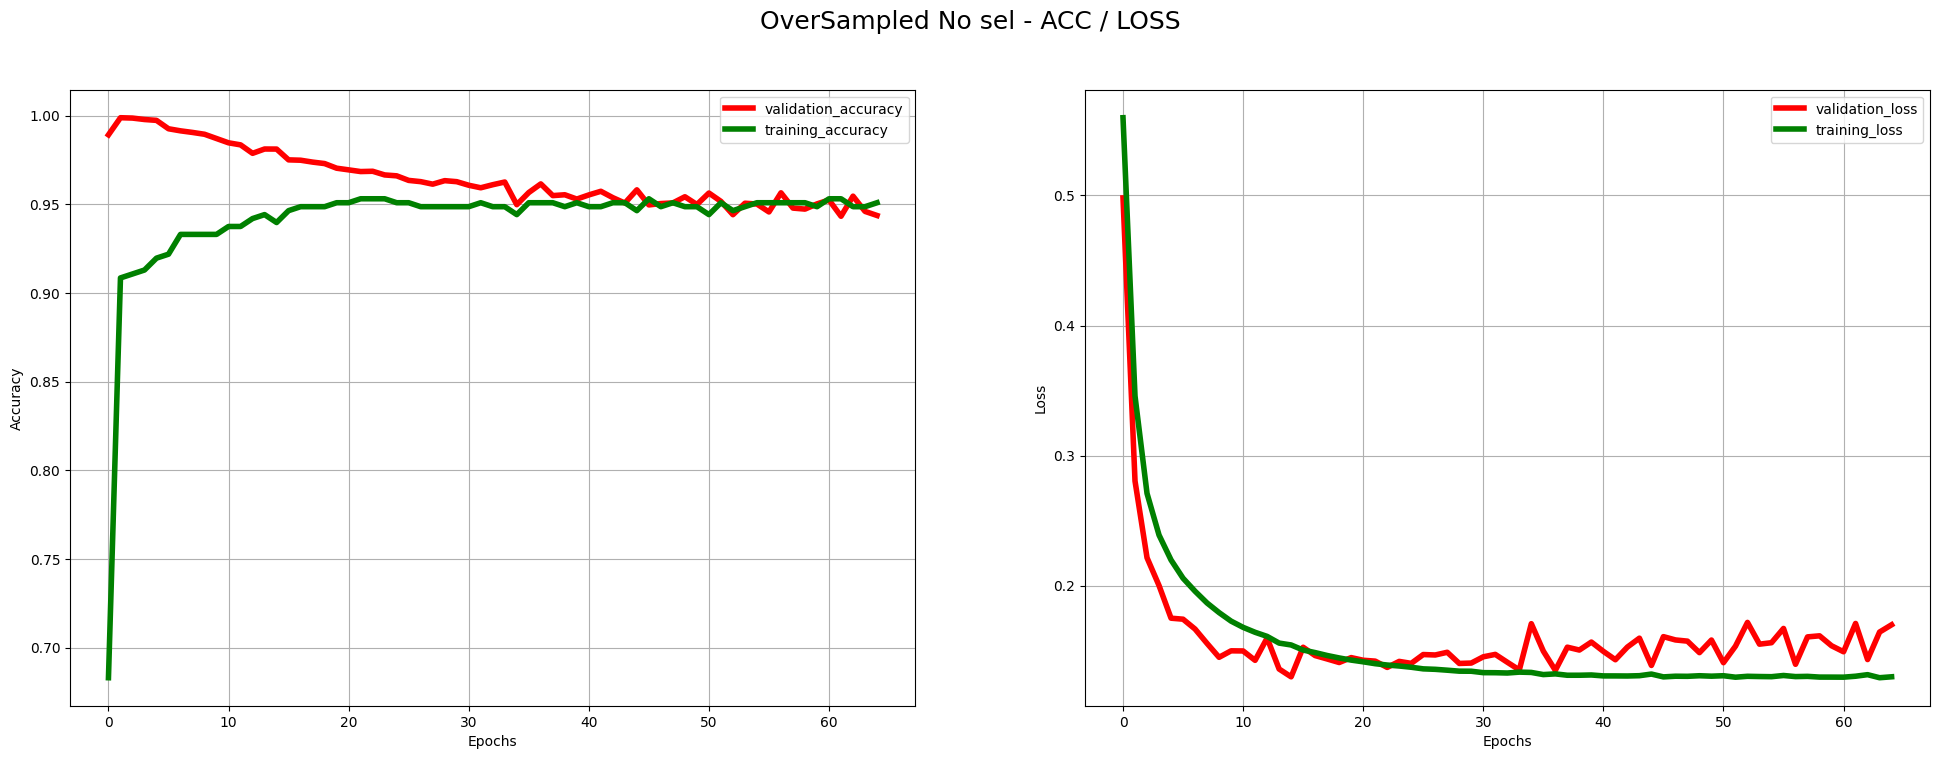

In [14]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 672us/step
[[97566  1945]
 [   24   148]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     99511
         1.0       0.07      0.86      0.13       172

    accuracy                           0.98     99683
   macro avg       0.54      0.92      0.56     99683
weighted avg       1.00      0.98      0.99     99683



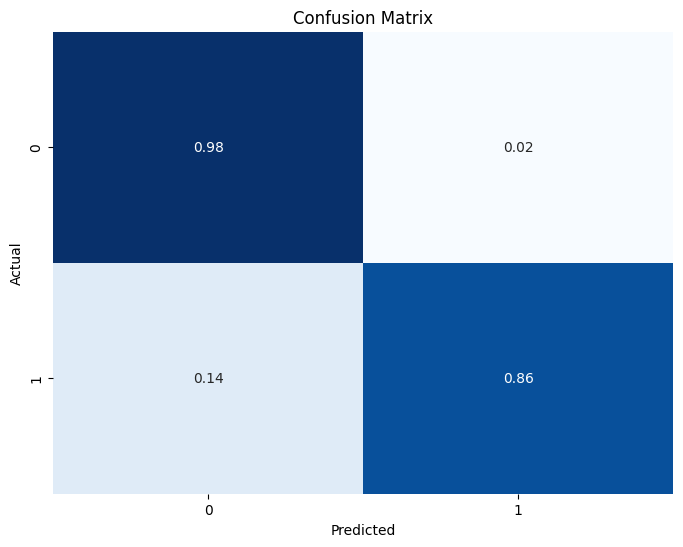

In [15]:
y_pred = model.predict(under_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# New Builder

In [16]:

def build_best_over_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_over_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/over_best_sel_shallow_nn/tuner0.json


## Over Sampling - Best selection

In [17]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
print("GPUS: ", tf.config.list_physical_devices('GPU'))

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



GPUS:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found:
- units: 192
- activation: sigmoid
- learning_rate: 0.01

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9616 - loss: 0.1019 - val_accuracy: 0.9966 - val_loss: 0.0119
Epoch 2/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 936us/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.9978 - val_loss: 0.0094
Epoch 3/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 8s 938us/step - accuracy: 0.9990 - loss: 0.0047 - val_accuracy: 0.9987 - val_loss: 0.0068
Epoch 4/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 877us/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0087
Epoch 5/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 906us/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9984 - val_loss: 0.0087
Epoch 6/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 867us/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9990 - val_loss: 0.0064
Epoch 7/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 891us/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9987 - val_loss: 0.0074
Epoch 8/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 851us/step - accuracy: 0.9995 - loss: 0.0024

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 707us/step - accuracy: 0.9986 - loss: 0.0089


# Plot of Training and Validation Accuracy/Loss

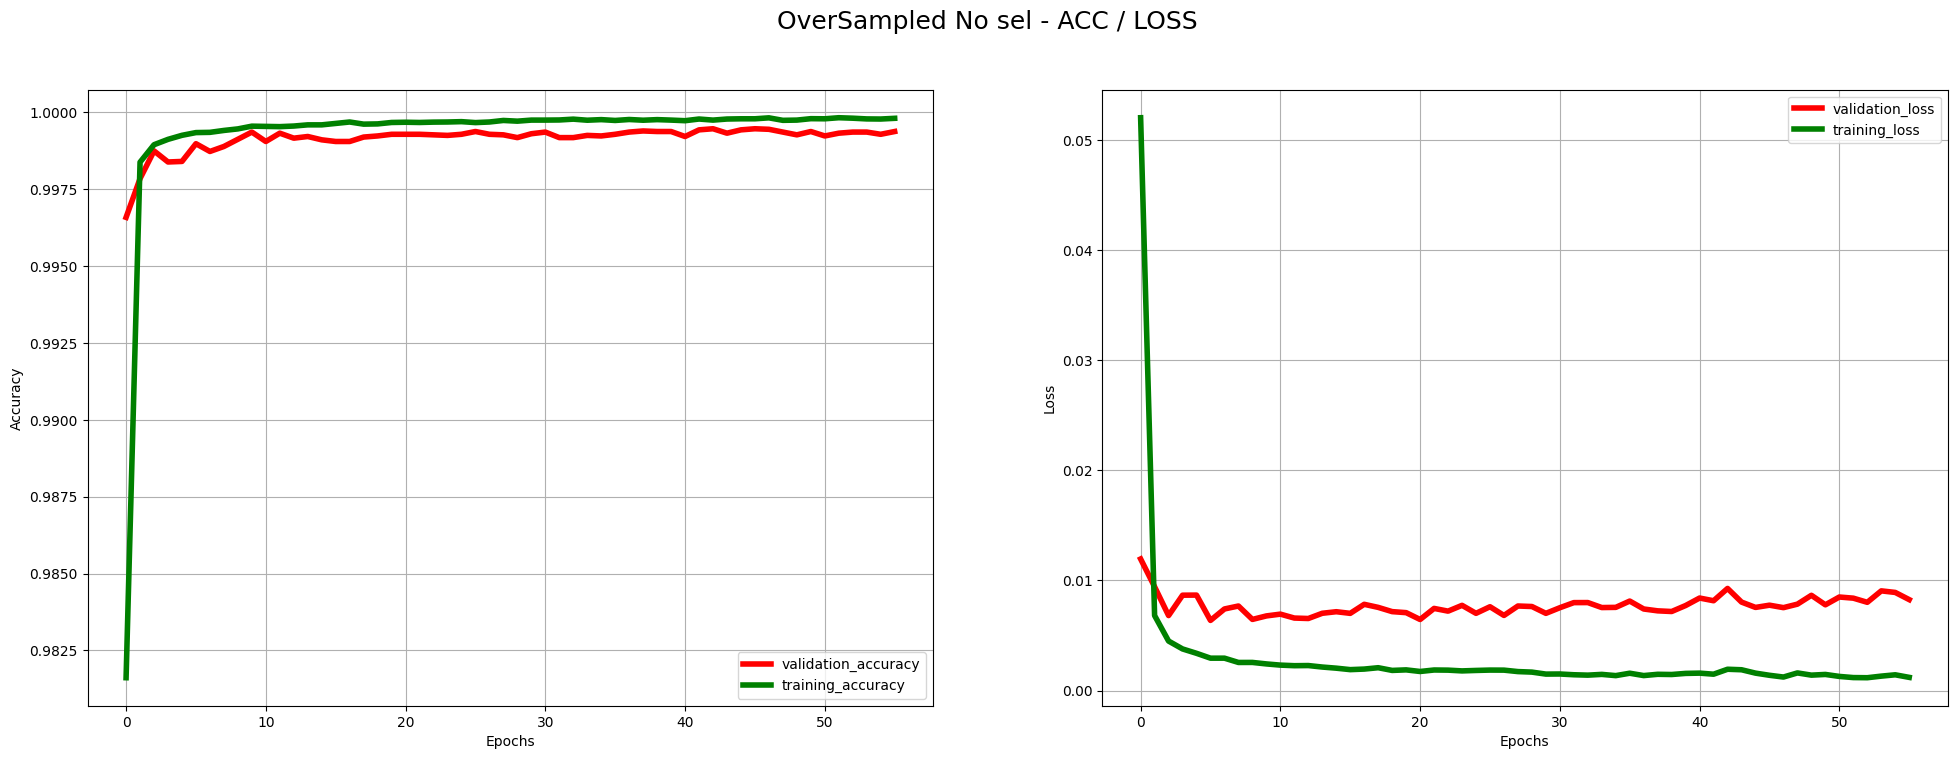

In [18]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step
[[99406   105]
 [   37   135]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99511
         1.0       0.56      0.78      0.66       172

    accuracy                           1.00     99683
   macro avg       0.78      0.89      0.83     99683
weighted avg       1.00      1.00      1.00     99683



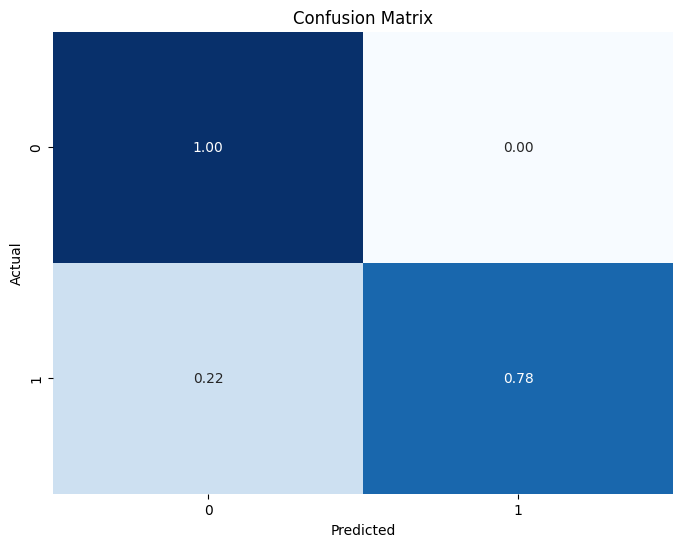

In [19]:
y_pred = model.predict(over_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()